# Multistep VAR Model with all Variables - Monthly Data

In [328]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import Statsmodels
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

Let's test the VAR model with monthly data.

Import the data (I'll first try with monthly data).

In [329]:
dvar = pd.read_csv("../Data/monthly_data.csv")

In [330]:
dvar = dvar.dropna()
dvar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94 entries, 1 to 94
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   datetime                 94 non-null     object 
 1   suction_tension (20cm)   94 non-null     float64
 2   suction_tension (40cm)   94 non-null     float64
 3   suction_tension (70cm)   94 non-null     float64
 4   water_temperature        94 non-null     float64
 5   barometric_pressure_qfe  94 non-null     float64
 6   dew_point                94 non-null     float64
 7   water_level              94 non-null     float64
 8   inflow_linth (m3/s)      94 non-null     float64
 9   outflow_limmat (m3/s)    94 non-null     float64
 10  precipitation (mm)       94 non-null     float64
 11  Evapotranspiration (mm)  94 non-null     float64
 12  change_rate              94 non-null     float64
dtypes: float64(12), object(1)
memory usage: 10.3+ KB


In [331]:
# convert DateTime column into datetime format
dvar["datetime"] = pd.to_datetime(dvar['datetime'])
# set DateTime as index
dvar.set_index("datetime", inplace=True)
dvar.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 94 entries, 2012-02-29 to 2019-11-30
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   suction_tension (20cm)   94 non-null     float64
 1   suction_tension (40cm)   94 non-null     float64
 2   suction_tension (70cm)   94 non-null     float64
 3   water_temperature        94 non-null     float64
 4   barometric_pressure_qfe  94 non-null     float64
 5   dew_point                94 non-null     float64
 6   water_level              94 non-null     float64
 7   inflow_linth (m3/s)      94 non-null     float64
 8   outflow_limmat (m3/s)    94 non-null     float64
 9   precipitation (mm)       94 non-null     float64
 10  Evapotranspiration (mm)  94 non-null     float64
 11  change_rate              94 non-null     float64
dtypes: float64(12)
memory usage: 9.5 KB


Visualize the Time Series

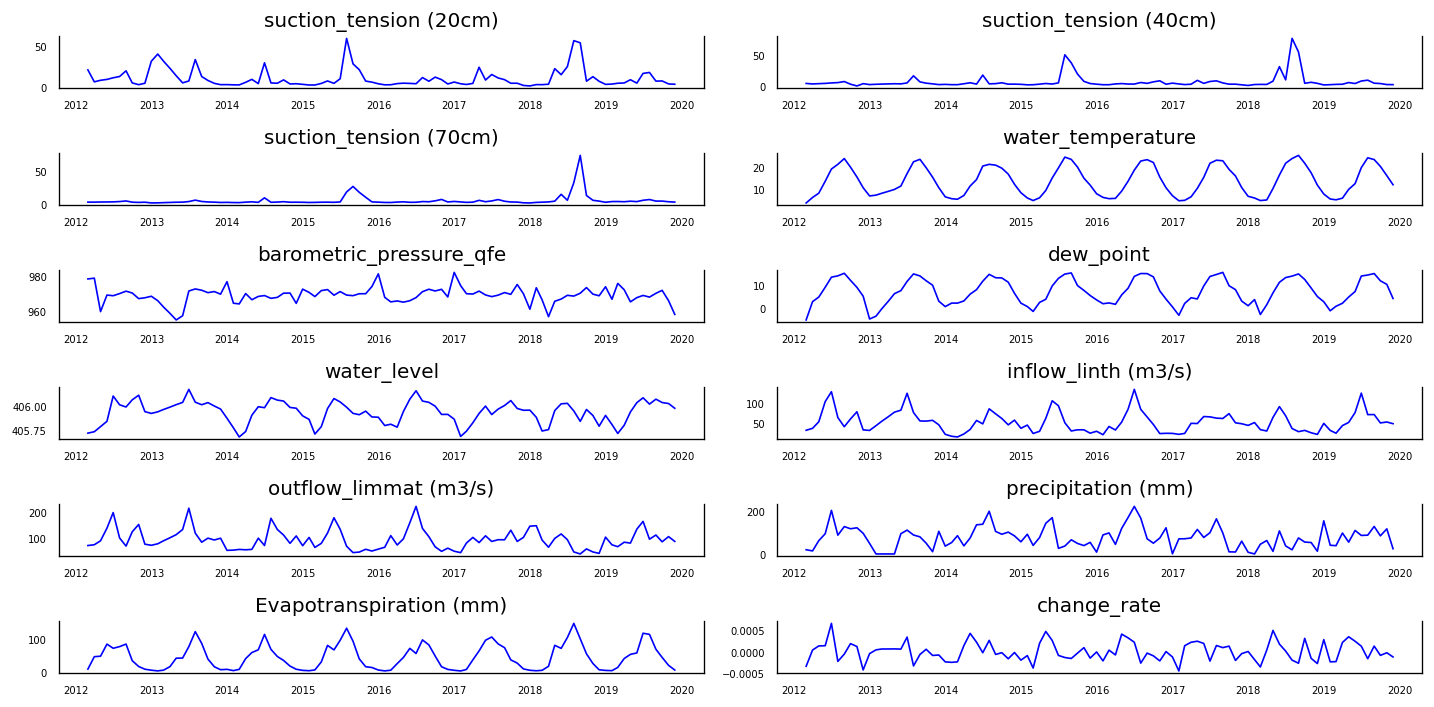

In [332]:
fig, axes = plt.subplots(nrows=6, ncols=2, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = dvar[dvar.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    # Decorations
    ax.set_title(dvar.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [333]:
# drop variable change rate
dvar.drop(columns="change_rate", inplace=True)

As shown in the figure above, there is quite some seasonality.

Check for causality with the Granger test
This test does more check whether one variable explains the other one in terms of forecasting instead of checking for a traditional causality  

In [334]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    
    # The rows are the response variable, columns are predictors. 
    # The values in the table are the P-Values. A P-Value smaller than the significance level (0.05), leads to a rejection of the Null Hypothesis
    # which implies that X "Granger causes" Y.

    dvar = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in dvar.columns:
        for r in dvar.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            dvar.loc[r, c] = min_p_value
    dvar.columns = [var + '_x' for var in variables]
    dvar.index = [var + '_y' for var in variables]
    return dvar

grangers_causation_matrix(dvar, variables = dvar.columns) 

,suction_tension (20cm)_x,suction_tension (40cm)_x,suction_tension (70cm)_x,water_temperature_x,barometric_pressure_qfe_x,dew_point_x,water_level_x,inflow_linth (m3/s)_x,outflow_limmat (m3/s)_x,precipitation (mm)_x,Evapotranspiration (mm)_x
suction_tension (20cm)_y,1.0000,0.3587,0.0335,0.0192,0.0034,0.1014,0.0025,0.0003,0.0054,0.0057,0.0002
suction_tension (40cm)_y,0.0361,1.0000,0.0000,0.0087,0.0182,0.0019,0.0021,0.0037,0.0555,0.0006,0.0000
suction_tension (70cm)_y,0.0000,0.0000,1.0000,0.0216,0.0076,0.0032,0.0238,0.0624,0.4010,0.0081,0.0000
water_temperature_y,0.0035,0.0000,0.0000,1.0000,0.0069,0.0000,0.0002,0.0000,0.0000,0.0033,0.0000
barometric_pressure_qfe_y,0.3970,0.1907,0.1028,0.0010,1.0000,0.0063,0.1748,0.1129,0.3851,0.0364,0.0618
dew_point_y,0.0397,0.1455,0.4942,0.0000,0.0034,1.0000,0.0088,0.0000,0.0034,0.0013,0.0000
water_level_y,0.0154,0.0000,0.0001,0.0000,0.0004,0.0000,1.0000,0.0024,0.0006,0.0177,0.0000
inflow_linth (m3/s)_y,0.0056,0.0000,0.0000,0.0000,0.0003,0.0000,0.0008,1.0000,0.0070,0.0425,0.0000
outflow_limmat (m3/s)_y,0.0331,0.0001,0.0030,0.0004,0.0042,0.0010,0.0196,0.0538,1.0000,0.0050,0.0000
precipitation (mm)_y,0.0042,0.0629,0.0413,0.0000,0.0000,0.0018,0.0039,0.0028,0.0006,1.0000,0.0008


The rows are the Response (Y) and the columns are the predictor series (X).

Cointegration test.

In [335]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(dvar, alpha=0.05): 
    out = coint_johansen(dvar,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(dvar.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(dvar)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
suction_tension (20cm) ::  502.87    > 263.2603  =>   True
suction_tension (40cm) ::  358.64    > 219.4051  =>   True
suction_tension (70cm) ::  262.81    > 179.5199  =>   True
water_temperature ::  183.26    > 143.6691  =>   True
barometric_pressure_qfe ::  113.29    > 111.7797  =>   True
dew_point ::  71.08     > 83.9383   =>   False
water_level ::  40.73     > 60.0627   =>   False
inflow_linth (m3/s) ::  19.32     > 40.1749   =>   False
outflow_limmat (m3/s) ::  6.85      > 24.2761   =>   False
precipitation (mm) ::  1.77      > 12.3212   =>   False
Evapotranspiration (mm) ::  0.21      > 4.1296    =>   False


Order of integration(d) is nothing but the number of differencing required to make a non-stationary time series stationary.

Now, when you have two or more time series, and there exists a linear combination of them that has an order of integration (d) less than that of the individual series, then the collection of series is said to be cointegrated.

Split the data

In [336]:
nobs = 11
dvar_train, dvar_test = dvar[0:-nobs], dvar[-nobs:]

print(dvar_train.shape)  
print(dvar_test.shape)

(83, 11)
(11, 11)


Stationarity.
For the VAR Model only stationary time series can be used. In order to verify it, we are going to use the ADF test.

In [337]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [338]:
for name, column in dvar_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "suction_tension (20cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.2235
 No. Lags Chosen       = 0
 Critical value 1%     = -3.513
 Critical value 5%     = -2.897
 Critical value 10%    = -2.586
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "suction_tension (40cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.2311
 No. Lags Chosen       = 0
 Critical value 1%     = -3.513
 Critical value 5%     = -2.897
 Critical value 10%    = -2.586
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "suction_tension (70cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has uni

C:\Users\lucal\AppData\Local\Temp\ipykernel_30132\1179845333.py:1: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in dvar_train.iteritems():


All except water level are stationary. We need to difference the variables and then check the ADF one more time.

In [339]:
# difference the training data once
dvar_differenced = dvar_train.diff().dropna()

In [340]:
# check again with the ADF test whether all series are now stationary
for name, column in dvar_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "suction_tension (20cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.2044
 No. Lags Chosen       = 1
 Critical value 1%     = -3.515
 Critical value 5%     = -2.898
 Critical value 10%    = -2.586
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "suction_tension (40cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.6383
 No. Lags Chosen       = 4
 Critical value 1%     = -3.518
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "suction_tension (70cm)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit 

C:\Users\lucal\AppData\Local\Temp\ipykernel_30132\3510589548.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in dvar_differenced.iteritems():


c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


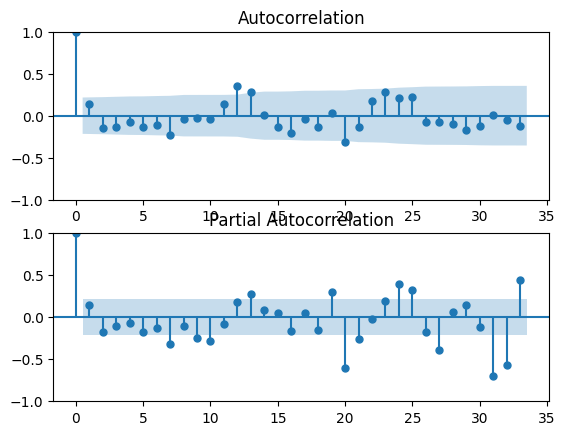

In [341]:
# plot autocorrelation and partial autocorrelation
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(dvar_differenced["water_level"], lags=33, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(dvar_differenced["water_level"], lags=33, ax=ax[1])
plt.show()

# it seems like the lags for the partial autocorrelation are mostly insignificant which means that in combination with the ADF test (p-calue < 0.05) that the water level series
# is now also stationary

Selection of the p order for the VAR.

In [342]:
model = VAR(dvar_differenced)

maxlags = 4

print(model.select_order(maxlags))
print(model.fit(maxlags=maxlags, ic='aic').summary())

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 4, BIC -> 1, FPE -> 4, HQIC ->  4>
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 30, Nov, 2022
Time:                     09:52:57
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                    44.3801
Nobs:                     78.0000    HQIC:                   35.4113
Log likelihood:          -1869.99    FPE:                3.56304e+13
AIC:                      29.4241    Det(Omega_mle):     2.37632e+11
--------------------------------------------------------------------
Results for equation suction_tension (20cm)
                                coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------
const                             -0.182745         1.1

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [344]:
# instantiate model with the differenced data
model = VAR(dvar_differenced)
# check different performance measures for a range of lags to see which one performs best 
# everything from lag 5 onwards causes an error so we only include lags up until 4
for i in [1,2,3,4,5]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  34.67694722183221
BIC :  38.57901251092804
FPE :  1176253563879137.2
HQIC:  36.2425069480848 

Lag Order = 2
AIC :  33.94877374613486
BIC :  41.48193297829101
FPE :  665945312997272.9
HQIC:  36.969032841056126 

Lag Order = 3
AIC :  31.982438023810676
BIC :  43.199824059540624
FPE :  150060882617554.47
HQIC:  36.476466066569934 

Lag Order = 4
AIC :  29.424083918594597
BIC :  44.38012070335547
FPE :  35630422706349.49
HQIC:  35.411260160763135 

Lag Order = 5
AIC :  25.13345530006769
BIC :  43.88389867489717
FPE :  6089267404272.046
HQIC:  32.63346792786719 



c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Let's try lag 3.

Train the model with the lag 3.

In [366]:
model_fitted = model.fit(3)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 30, Nov, 2022
Time:                     09:57:28
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                    43.1998
Nobs:                     79.0000    HQIC:                   36.4765
Log likelihood:          -2122.36    FPE:                1.50061e+14
AIC:                      31.9824    Det(Omega_mle):     2.92619e+12
--------------------------------------------------------------------
Results for equation suction_tension (20cm)
                                coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------
const                              0.016091         1.158958            0.014           0.989
L1.suction_tension (20cm)         -0.744108         0.295681           -2.517        

Residuals with Durbin Watson Statistic

In [367]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(dvar.columns, out):
    print(col, ':', round(val, 2))

suction_tension (20cm) : 2.16
suction_tension (40cm) : 2.23
suction_tension (70cm) : 2.01
water_temperature : 2.36
barometric_pressure_qfe : 2.1
dew_point : 2.13
water_level : 1.87
inflow_linth (m3/s) : 1.88
outflow_limmat (m3/s) : 1.9
precipitation (mm) : 2.0
Evapotranspiration (mm) : 2.27


CHECK THE MEANING

Forecasting

In [368]:
lag_order = model_fitted.k_ar
print(lag_order)  

# Input data for forecasting
forecast_input = dvar_differenced.values[-lag_order:]
forecast_input

3


array([[ 5.61599219e+00,  1.58585512e+00, -7.24756129e+00,
        -4.29771625e+00, -3.67459580e+00, -3.79397990e+00,
        -6.33206788e-02, -5.92968620e+00, -1.16677711e+01,
        -2.10000000e+00, -2.98800000e+01],
       [-5.72901165e+00, -1.69099698e+00, -1.21471789e+00,
        -5.51411960e+00, -9.26919763e-01, -3.77922256e+00,
        -1.12429776e-01, -4.03596599e+00, -5.65278649e+00,
        -4.08000000e+01, -1.94100000e+01],
       [-3.82188172e+00, -2.52104167e+00, -1.76349462e+00,
        -4.04307945e+00,  5.04598641e+00, -2.33567055e+00,
         1.13277778e-01,  2.73421560e+01,  6.25459294e+01,
         1.42300000e+02, -1.97000000e+00]])

In [369]:
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
dvar_forecast = pd.DataFrame(fc, index=dvar.index[-nobs:], columns=dvar.columns + '_1d')
dvar_forecast

,suction_tension (20cm)_1d,suction_tension (40cm)_1d,suction_tension (70cm)_1d,water_temperature_1d,barometric_pressure_qfe_1d,dew_point_1d,water_level_1d,inflow_linth (m3/s)_1d,outflow_limmat (m3/s)_1d,precipitation (mm)_1d,Evapotranspiration (mm)_1d
datetime,,,,,,,,,,,
2019-01-31,-1.680313,0.156695,4.179977,-1.614456,2.629725,-1.927124,0.009270,1.142677,1.669185,-49.314523,16.438901
2019-02-28,5.533982,-8.079202,-6.165363,3.052107,-3.599471,2.796896,-0.063418,1.749962,-5.199028,-13.004907,24.226132
2019-03-31,9.066541,11.128050,-2.053729,4.021517,1.936101,3.292193,-0.030335,-8.422399,-15.239291,12.780334,31.520826
2019-04-30,-2.595056,4.927772,9.271357,2.925672,-4.881214,3.740867,0.067363,19.591751,27.793131,45.129596,1.071514
2019-05-31,-6.772295,-7.778296,-2.880281,2.337950,0.511875,2.796370,0.113134,8.266181,1.652660,-28.687717,0.894965
2019-06-30,3.016787,6.157886,0.492472,1.648873,4.297126,0.129432,0.074958,6.364152,5.934698,22.869327,6.676132
2019-07-31,5.775996,1.049008,3.256788,1.527938,0.477314,-0.041801,-0.047099,-13.725056,-16.441137,1.236470,0.361262
2019-08-31,-3.999474,-1.775544,-3.840965,-0.948234,0.216432,-0.532533,-0.043376,-7.936079,3.630594,-16.399434,-16.139649
2019-09-30,2.223557,3.137463,5.701524,-2.502618,0.072803,-2.646494,-0.075902,-16.222681,-24.779098,-23.443056,-18.609619


In [370]:
# function for inverting the differenced data
def invert_transformation(dvar_train, dvar_forecast, first_diff=False): 
    dvar_fc = dvar_forecast.copy()
    columns = dvar_train.columns
    for col in columns:        
        dvar_fc[str(col)+'_forecast'] = dvar_train[col].iloc[-1] + dvar_fc[str(col)+'_1d'].cumsum()
    return dvar_fc

In [371]:
dvar_results = invert_transformation(dvar_train, dvar_forecast, first_diff=True)        
dvar_results.loc[:, ['suction_tension (20cm)_forecast', 'suction_tension (40cm)_forecast', 'suction_tension (70cm)_forecast', 'water_temperature_forecast', 'barometric_pressure_qfe_forecast',
                   'dew_point_forecast', 'water_level_forecast', 'inflow_linth (m3/s)_forecast', 'outflow_limmat (m3/s)_forecast', 'precipitation (mm)_forecast', 'Evapotranspiration (mm)_forecast']]

,suction_tension (20cm)_forecast,suction_tension (40cm)_forecast,suction_tension (70cm)_forecast,water_temperature_forecast,barometric_pressure_qfe_forecast,dew_point_forecast,water_level_forecast,inflow_linth (m3/s)_forecast,outflow_limmat (m3/s)_forecast,precipitation (mm)_forecast,Evapotranspiration (mm)_forecast
datetime,,,,,,,,,,,
2019-01-31,1.311555,1.937945,6.295232,6.169595,976.393882,0.648548,405.910381,51.064955,105.357762,105.685477,19.958901
2019-02-28,6.845538,-6.141257,0.129869,9.221702,972.794411,3.445444,405.846962,52.814917,100.158734,92.680571,44.185033
2019-03-31,15.912079,4.986793,-1.923860,13.243219,974.730512,6.737638,405.816627,44.392518,84.919443,105.460905,75.705859
2019-04-30,13.317023,9.914565,7.347497,16.168891,969.849298,10.478505,405.883990,63.984269,112.712574,150.590500,76.777373
2019-05-31,6.544728,2.136270,4.467216,18.506841,970.361173,13.274875,405.997124,72.250450,114.365233,121.902784,77.672339
2019-06-30,9.561516,8.294156,4.959688,20.155713,974.658299,13.404307,406.072082,78.614602,120.299931,144.772111,84.348471
2019-07-31,15.337512,9.343164,8.216476,21.683651,975.135614,13.362506,406.024982,64.889546,103.858794,146.008580,84.709733
2019-08-31,11.338038,7.567620,4.375511,20.735417,975.352045,12.829973,405.981606,56.953467,107.489388,129.609146,68.570084
2019-09-30,13.561595,10.705083,10.077035,18.232799,975.424849,10.183479,405.905704,40.730787,82.710289,106.166090,49.960465


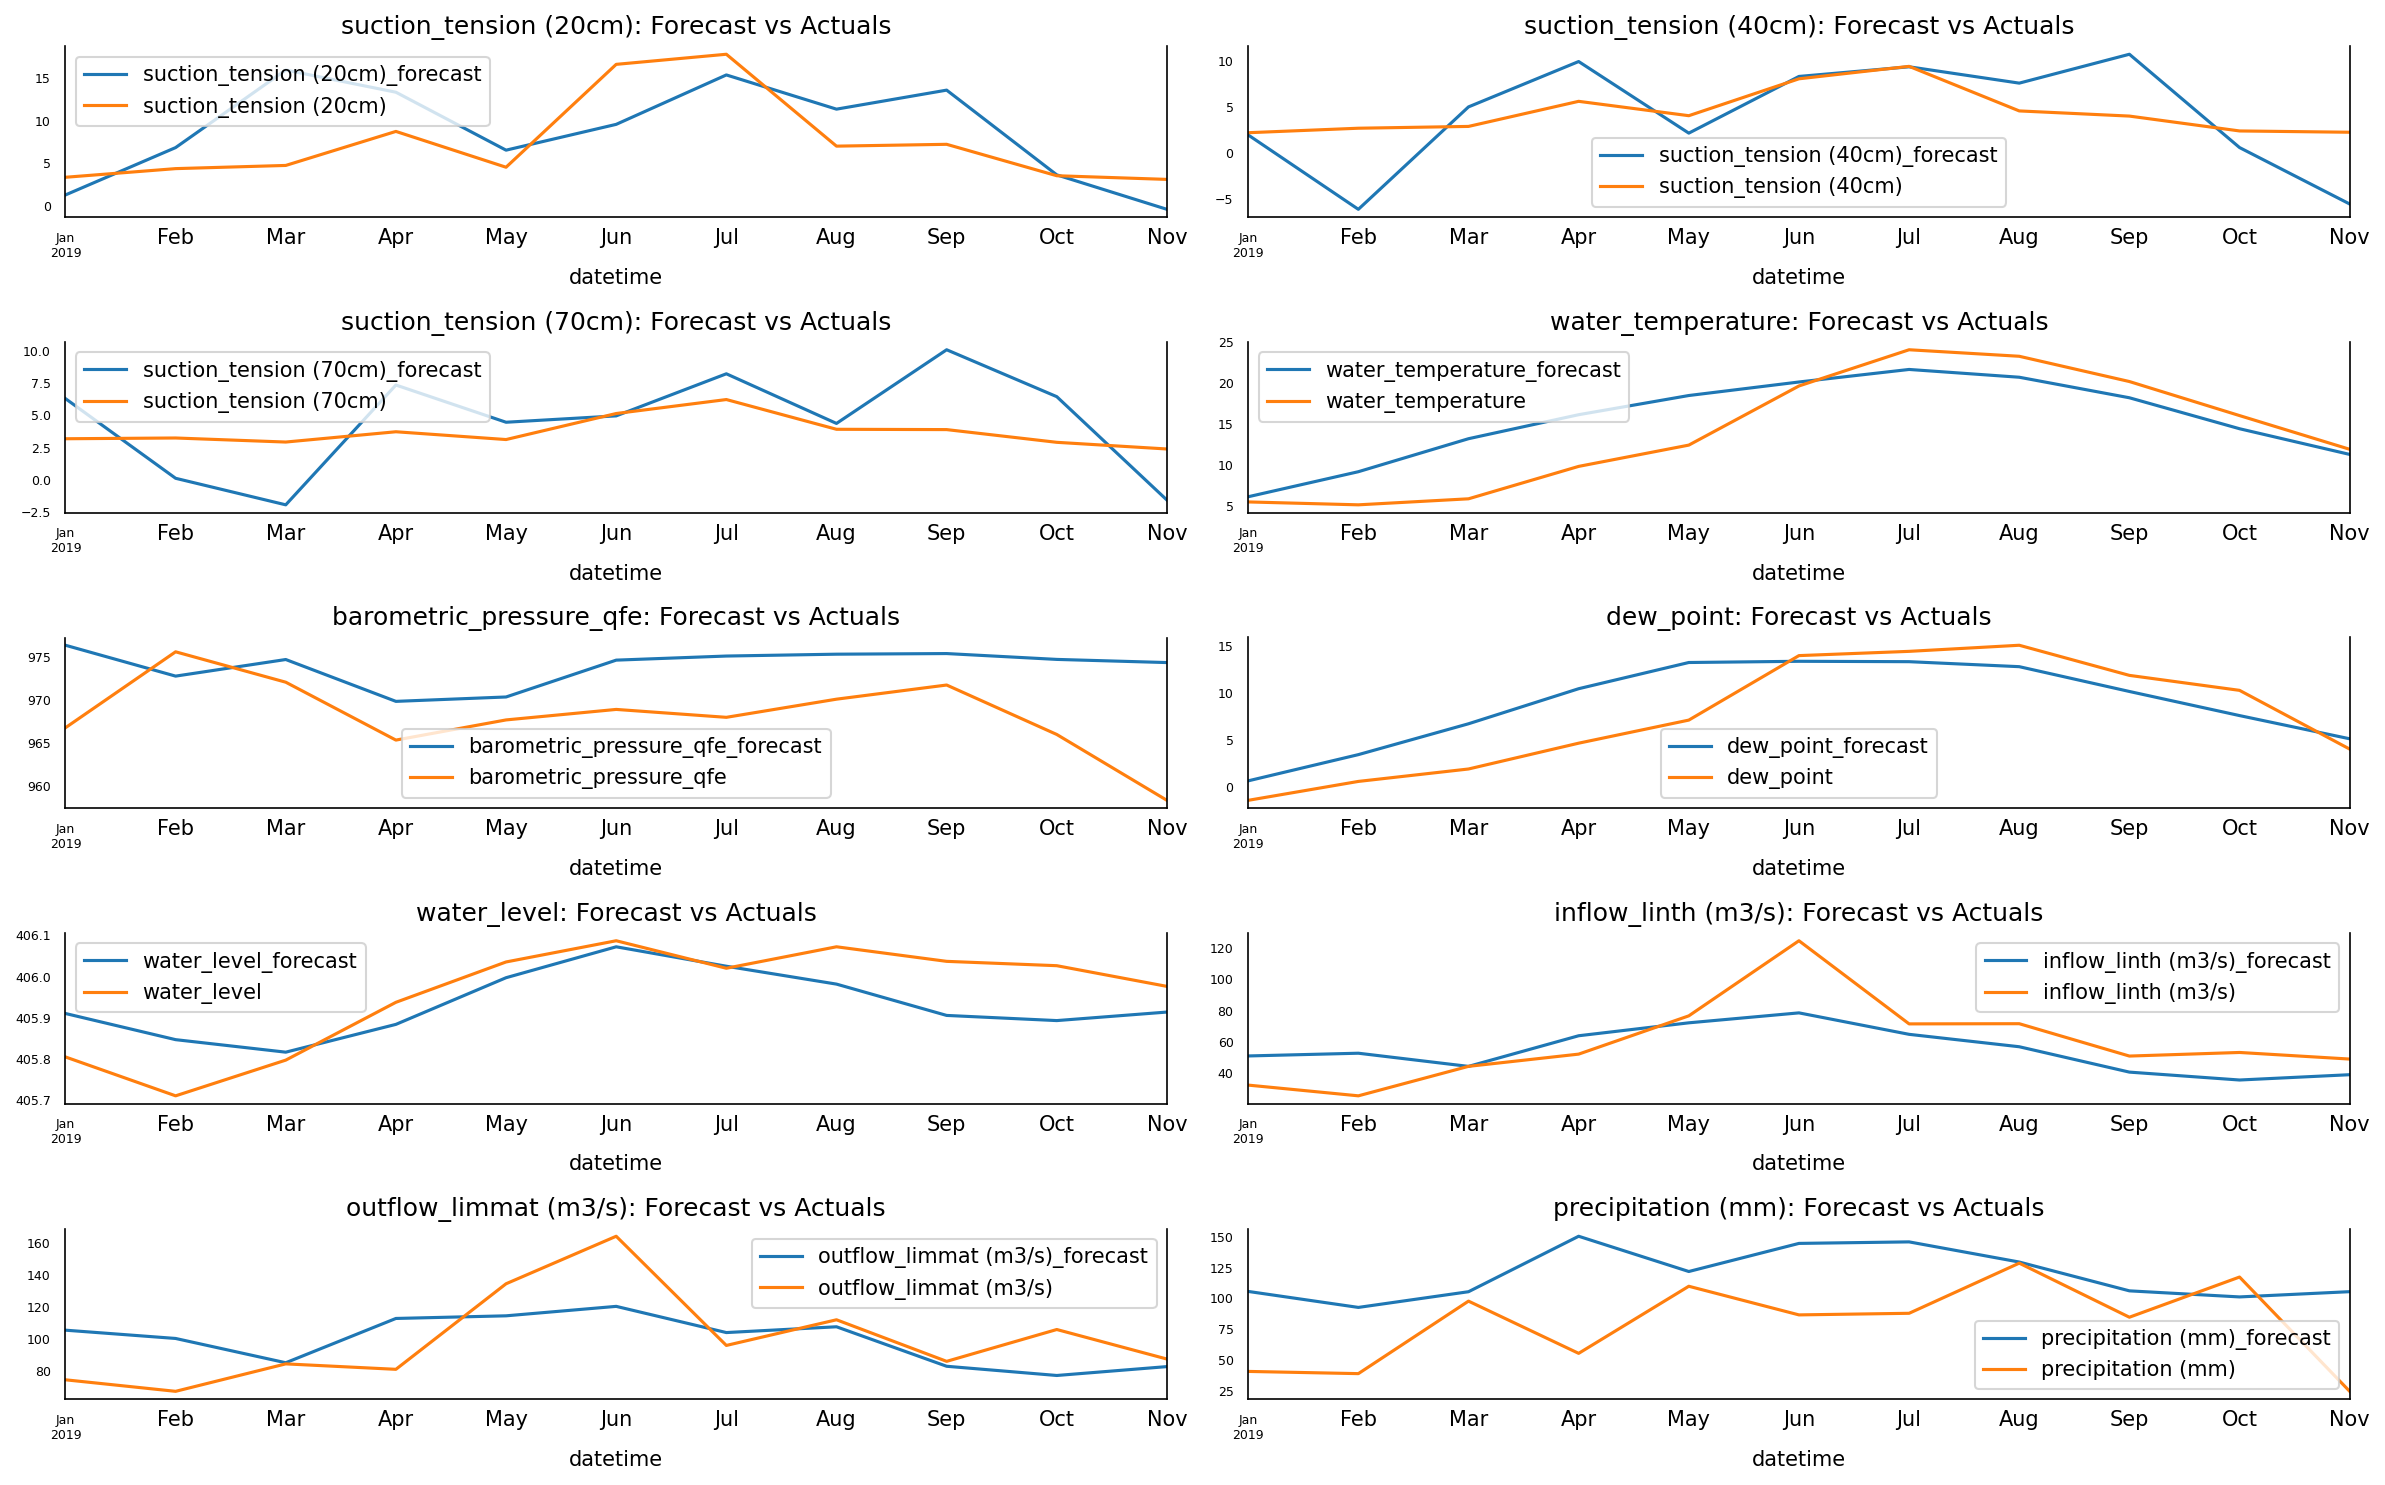

In [372]:
fig, axes = plt.subplots(nrows=int(len(dvar.columns)/2), ncols=2, dpi=150, figsize=(16,10))
for i, (col,ax) in enumerate(zip(dvar.columns, axes.flatten())):
    dvar_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    dvar_test[col][-nobs:].plot(legend=True, ax=ax)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()


<AxesSubplot: xlabel='datetime'>

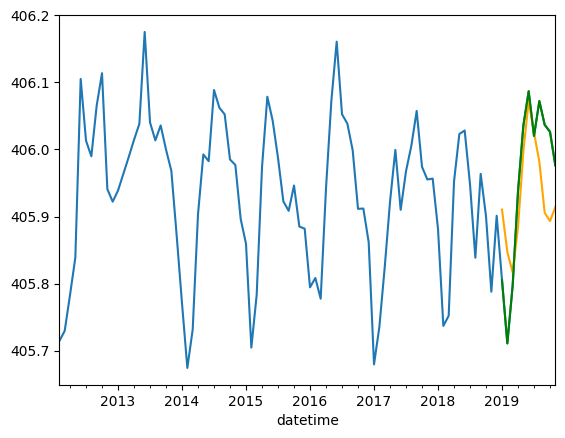

In [373]:
import matplotlib.pyplot as plt
dvar["water_level"].plot()
dvar_results["water_level_forecast"].plot(color="orange")
dvar_test["water_level"].plot(color="green")

In [374]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: water_level')
accuracy_prod = forecast_accuracy(dvar_results['water_level_forecast'].values, dvar_test['water_level'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))


Forecast Accuracy of: water_level
mape :  0.0002
me :  -0.0234
mae :  0.0717
mpe :  -0.0001
rmse :  0.0861
corr :  0.74
minmax :  0.0002


C:\Users\lucal\AppData\Local\Temp\ipykernel_30132\522686556.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\lucal\AppData\Local\Temp\ipykernel_30132\522686556.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


In [ ]:
nobs 24

lag=4
mape :  0.0003
me :  0.1
mae :  0.1077
mpe :  0.0002
rmse :  0.1316
corr :  0.6359
minmax :  0.0003
lag=4 (undiff)
mape :  0.0003
me :  0.0505
mae :  0.1167
mpe :  0.0001
rmse :  0.1565
corr :  0.247
minmax :  0.0003

lag=3
mape :  0.0002
me :  0.0543
mae :  0.0727
mpe :  0.0001
rmse :  0.0982
corr :  0.69
minmax :  0.0002
lag=3 undiff
mape :  0.0004
me :  0.137
mae :  0.1512
mpe :  0.0003
rmse :  0.1854
corr :  0.2162
minmax :  0.0004

lag=2
mape :  0.0002
me :  0.0347
mae :  0.0836
mpe :  0.0001
rmse :  0.1062
corr :  0.4547
minmax :  0.0002


nobs 11 

lag=4 diff
mape :  0.0002
me :  -0.0349
mae :  0.0697
mpe :  -0.0001
rmse :  0.0851
corr :  0.7721
minmax :  0.0002
lag=4 undiff
mape :  0.0001
me :  0.0205
mae :  0.0415
mpe :  0.0001
rmse :  0.0588
corr :  0.9231
minmax :  0.0001

lag=3 diff
mape :  0.0002
me :  -0.0234
mae :  0.0717
mpe :  -0.0001
rmse :  0.0861
corr :  0.74
minmax :  0.0002
lag=3 undiff
mape :  0.0002
me :  -0.003
mae :  0.07
mpe :  -0.0
rmse :  0.0837
corr :  0.7244
minmax :  0.0002

lag=2
mape :  0.0002
me :  -0.0064
mae :  0.0776
mpe :  -0.0
rmse :  0.0914
corr :  0.6922
minmax :  0.0002

lag=6
mape :  0.0017
me :  -0.025
mae :  0.6816
mpe :  -0.0001
rmse :  0.9039
corr :  -0.4933
minmax :  0.0017

nobs 6 undifferentiated

lag=4
mape :  0.0001
me :  -0.0189
mae :  0.0391
mpe :  -0.0
rmse :  0.0438
corr :  0.2017
minmax :  0.0001

lag=3
mape :  0.0001
me :  -0.0437
mae :  0.0437
mpe :  -0.0001
rmse :  0.052
corr :  0.6254
minmax :  0.0001

SyntaxError: invalid syntax (4157011631.py, line 1)